# Act 3: Generate from Data

In this notebook, you'll generate new video content from existing data - creating trailer clips automatically from your scene library. This typically means opening editing software for each clip, manually extracting frames, adding effects, exporting, then repeating this 100 times for 100 clips.

The techniques you'll learn apply to any workflow where you need to create derivative content at scale:

- Batch processing video clips (thumbnails, previews, social media clips)
- Generating variations of existing content (different aspect ratios, durations, styles)
- Creating derivative assets from source material (highlight reels, compilations)
- The same pattern works for images (generating thumbnails), audio (extracting clips), and documents (creating summaries)

## In this notebook
1. **Extract Frames** - Pull frames from scenes using computed columns
2. **Generate AI Prompts** - Use vision models to create content descriptions
3. **Create Video Content** - Generate trailers from AI prompts
4. **Generate Across All Scenes** - See how computed columns processed all scenes automatically

**Prerequisites:** You'll need a Gemini API key from [aistudio.google.com](https://aistudio.google.com/apikey). See [Pixeltable's API key configuration guide](https://docs.pixeltable.com/howto/cookbooks/core/workflow-api-keys) for setup instructions.

**Models used in this notebook:**
- `gemini-2.0-flash-exp` (Text-out models) - Used for generating text descriptions from images
- `imagen-4.0-generate` (Multi-modal generative models) - Used for generating images from text
- `veo-3.0-generate` (Multi-modal generative models) - Used for generating videos from images

First, we'll connect to our existing data from Acts 1 and 2.

In [1]:
import pixeltable as pxt
import pixeltable.functions as pxtf

In [2]:
pxt.list_tables()

Connected to Pixeltable database at: postgresql+psycopg://postgres:@/pixeltable?host=/Users/alison-pxt/.pixeltable/pgdata


['primetime_vids', 'sentences', 'scene_view']

In [3]:
# Get the scene_view from Act 2
scene_view = pxt.get_table('scene_view')

In [5]:
scene_view.drop_column(scene_view.trailer_image)
scene_view.drop_column(scene_view.trailer_prompt)
scene_view.drop_column(scene_view.beginning_frame)

In [6]:
scene_view

view 'scene_view' (of 'primetime_vids')

        Column Name             Type                                      Computed With
                pos    Required[Int]                                                   
      segment_start            Float                                                   
  segment_start_pts              Int                                                   
        segment_end            Float                                                   
    segment_end_pts              Int                                                   
      video_segment  Required[Video]                                                   
              audio  Required[Audio]                       extract_audio(video_segment)
      transcription   Required[Json]                    transcribe(audio, model='base')
    transcript_text           String                  transcription.text.astype(String)
    transcript_lang             Json                             transcription.language
              video            Video                                                   
              title           String                                                   
          promo_img            Image                                                   
         promo_text           String                                                   
           duration            Float                                get_duration(video)
             scenes             Json  video.scene_detect_histogram(fps=10,\n    thre...

## 01 - Extract Frames

In [7]:
# Extract beginning frame (0.5 seconds in)
scene_view.add_computed_column(
    beginning_frame=scene_view.video_segment.extract_frame(timestamp=0.5),
    if_exists='replace'
)

Added 10 column values with 0 errors in 0.33 s (30.14 rows/s)


10 rows updated.

pos,beginning_frame
1,
2,
4,

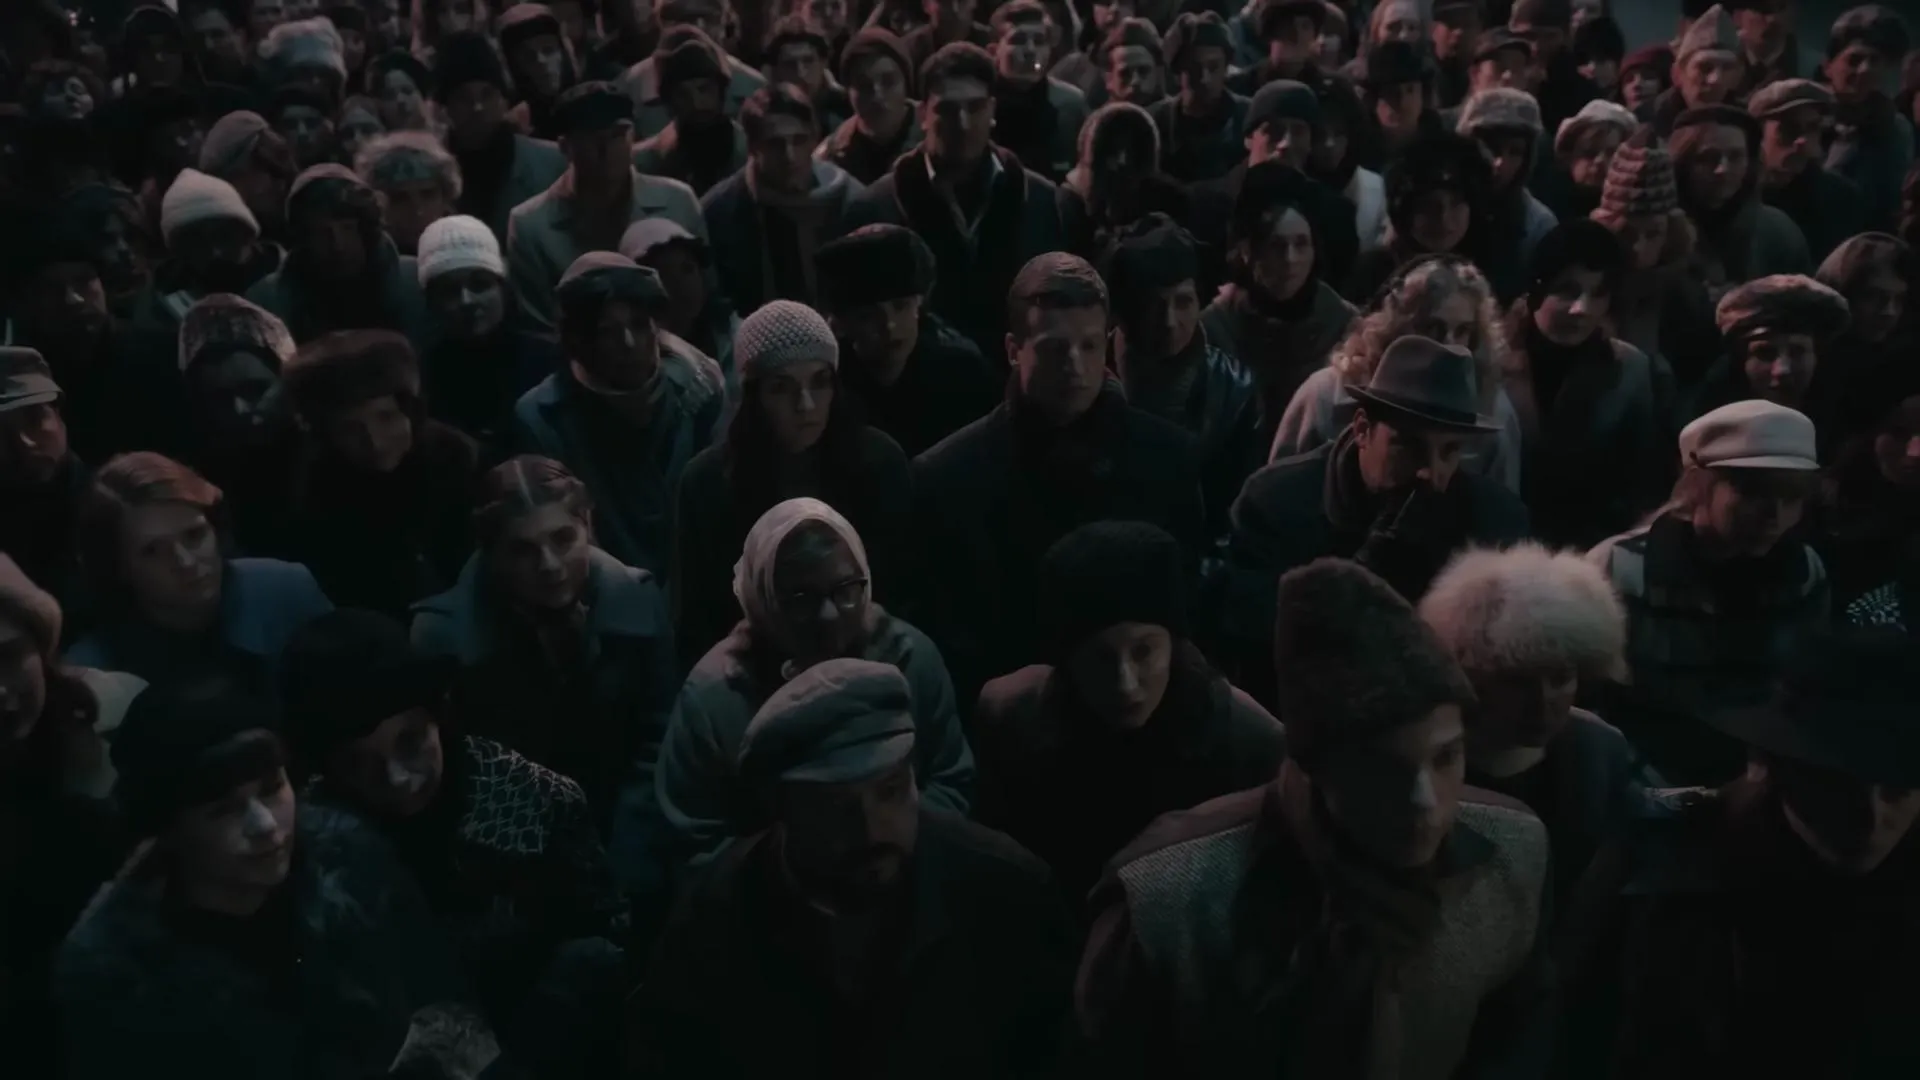
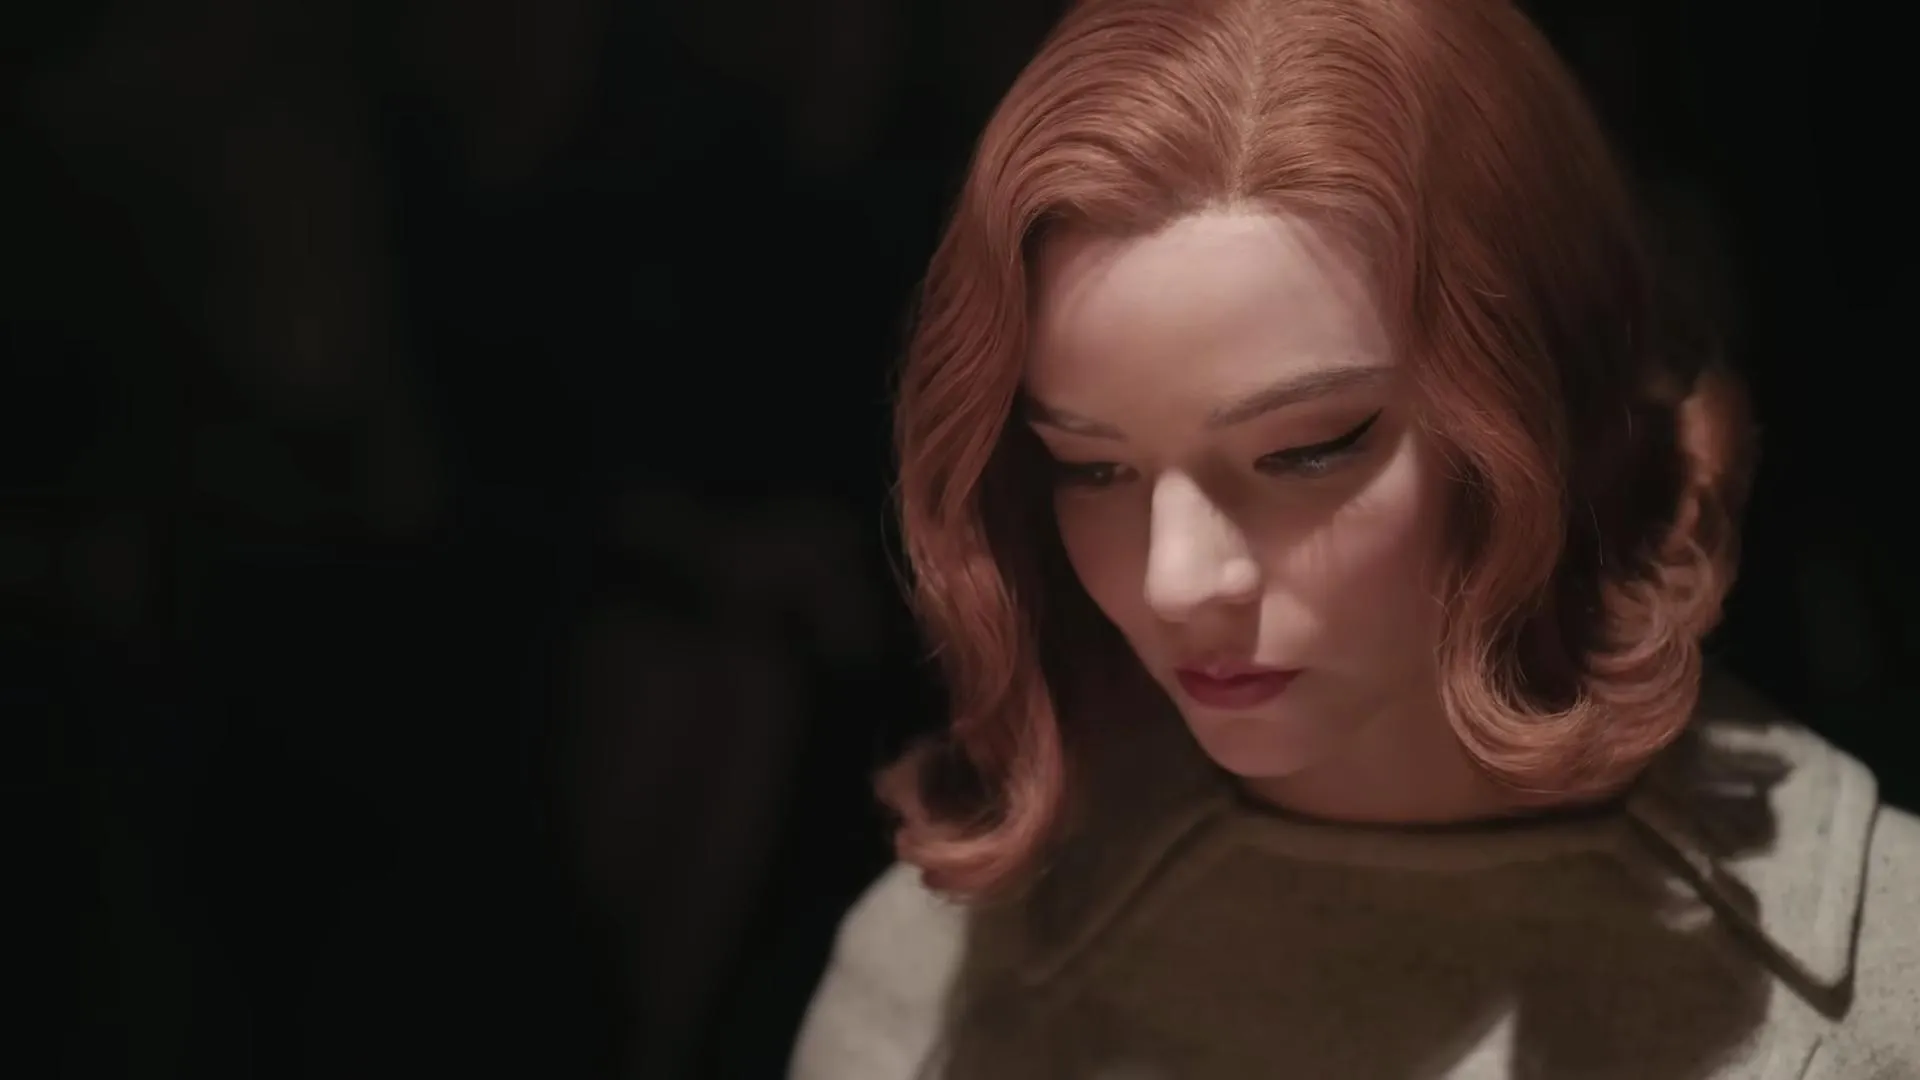
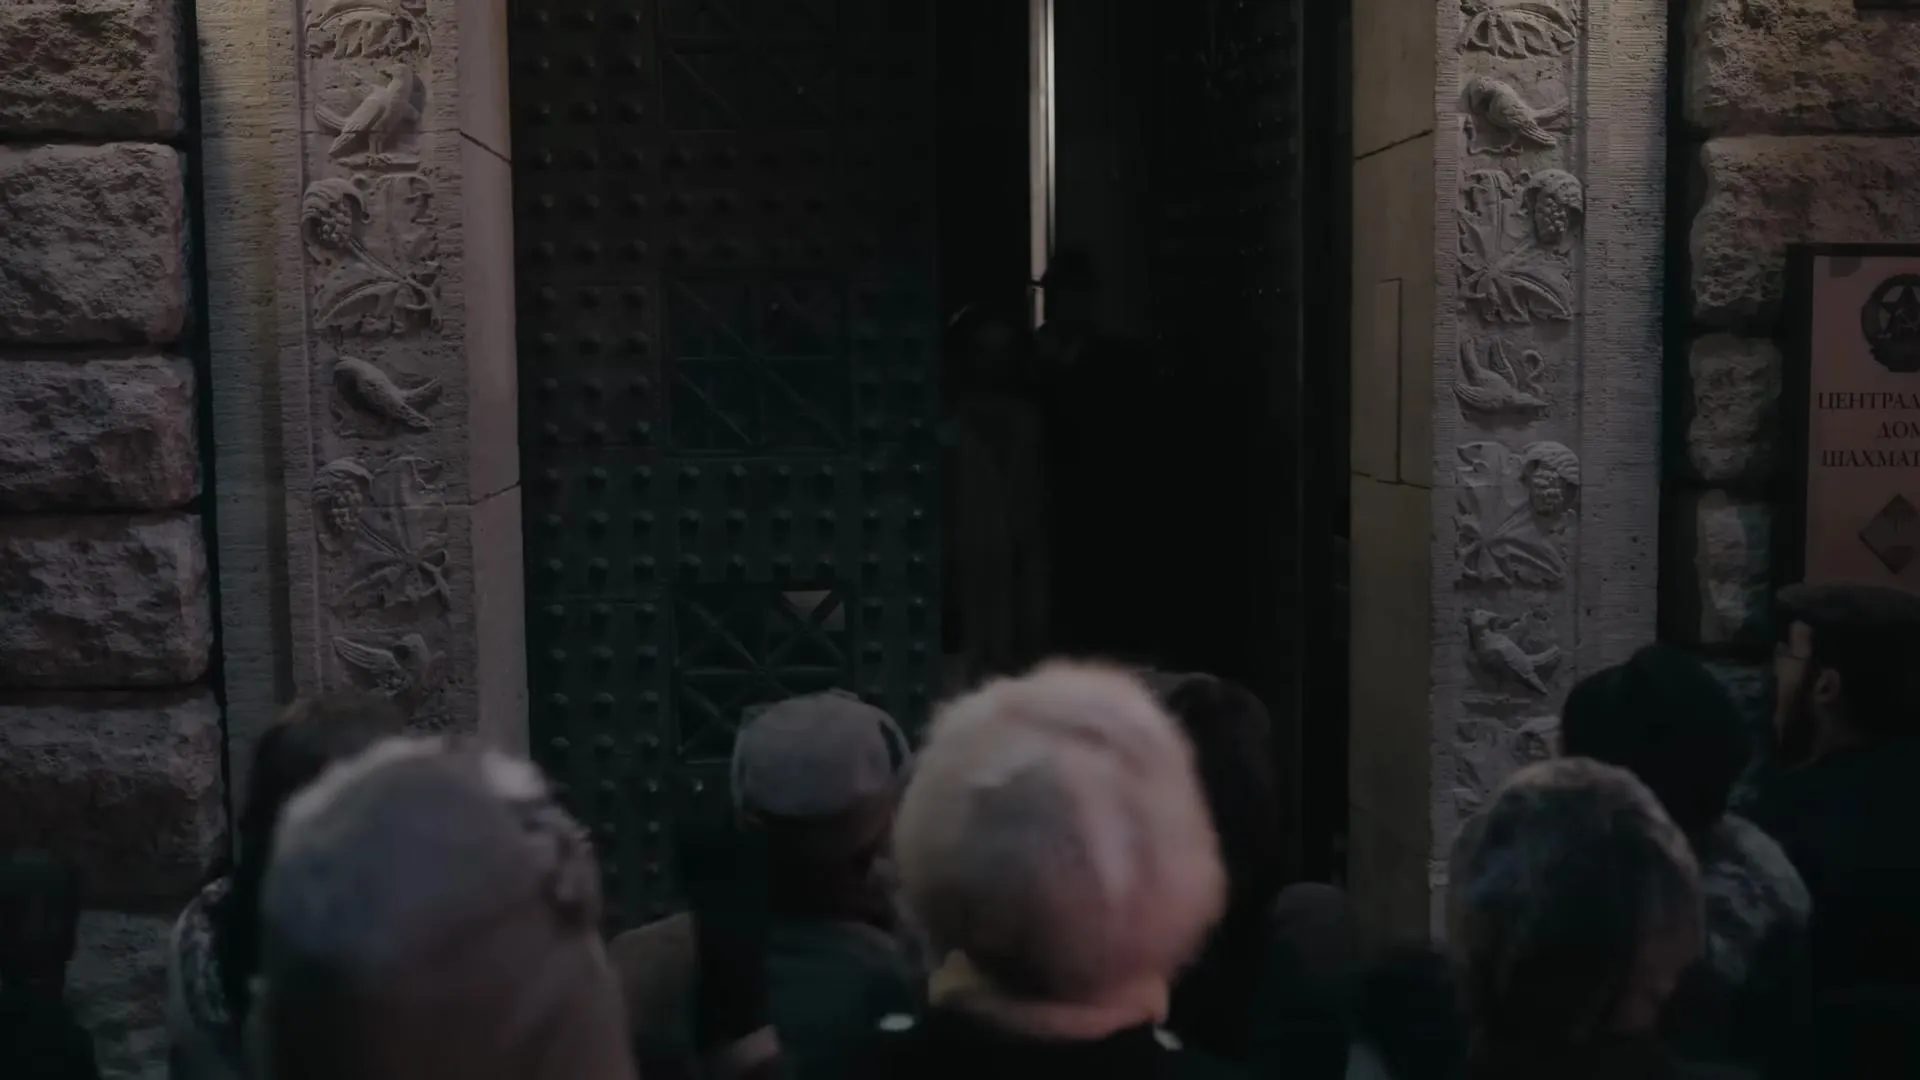

In [8]:
scene_view.select(scene_view.pos, scene_view.beginning_frame).limit(3).collect()

pos,beginning_frame
2,

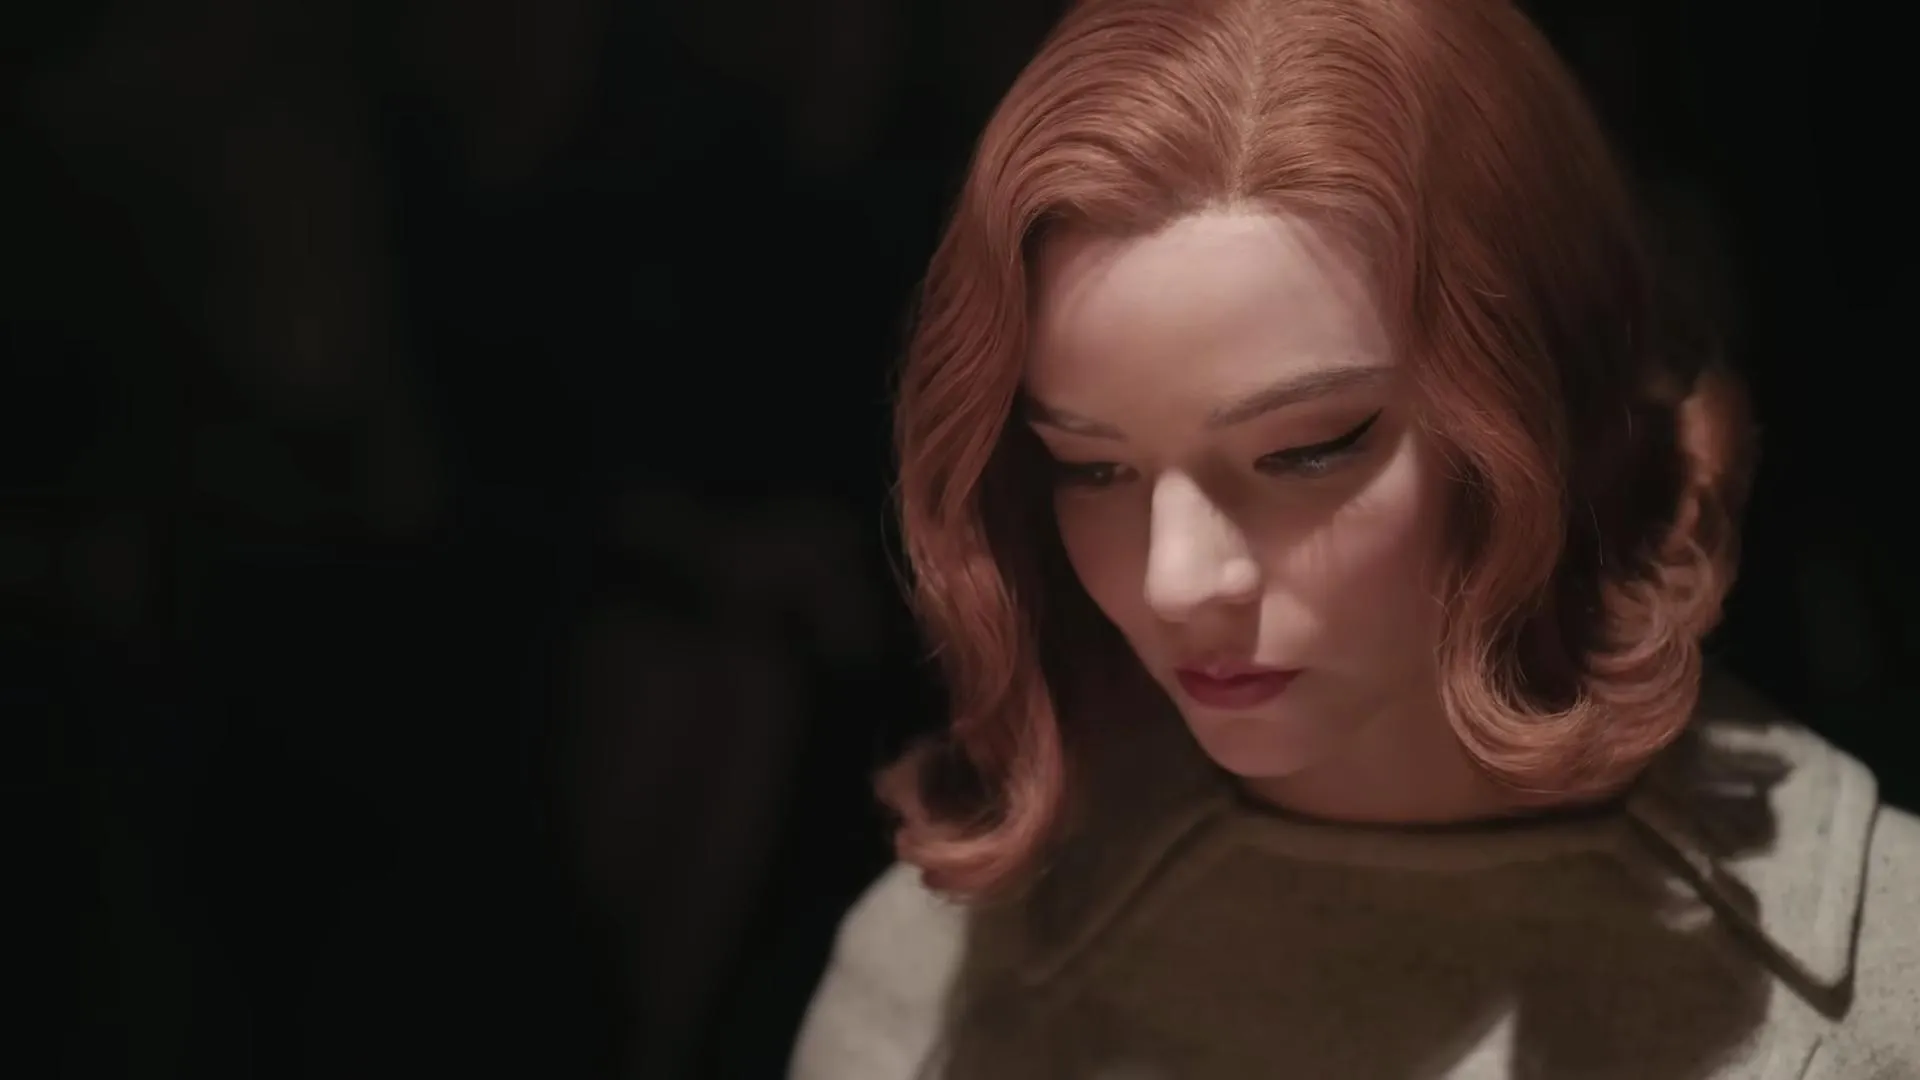

In [9]:
# View the extracted frame by scene position
scene_view.where(scene_view.pos == 2).select(
    scene_view.pos,
    scene_view.beginning_frame
).collect()

## 02 - Generate AI Prompts

Now let's use AI to generate creative trailer prompts for each scene.

We'll define a **Pixeltable expression** - a reusable transformation that references table columns. Expressions are powerful because:
- They can be used and reused in queries (`.select()`) or as computed columns (`.add_computed_column()`)
- When added as computed columns, they're automatically applied to new data
- They can reference multiple columns of any data type in a single operation

Here we'll create a multimodal expression that sends the frame image, transcript text, and movie context to Gemini's `gemini-2.0-flash-exp` m - combining vision and language understanding in one API call.

In [10]:
# Define the trailer prompt expression (save it to reuse)
trailer_prompt_expr = pxtf.gemini.generate_content(
    contents=[
        f'You are creating trailer prompts for an image generator. Movie: "{scene_view.title}". Description: {scene_view.promo_text}. This frame is from one scene. What is said: {scene_view.transcript_text}. Write ONLY a 1-2 sentence cinematic prompt for an image generator. Be visual and atmospheric. No text, no typography, no words in the image. Do not include any preamble or explanation.',
        scene_view.beginning_frame
    ],
    model='gemini-2.0-flash-exp'
)['candidates'][0]['content']['parts'][0]['text']

In [11]:
# Test on one scene first
scene_view.where(scene_view.pos == 2).select(
    scene_view.pos,
    scene_view.transcript_text,
    trailer_prompt=trailer_prompt_expr
).collect()

pos,transcript_text,trailer_prompt
2,It's your game. Take it. What?! Diamond shoulder lantern!,"Movie: The Queen's Gambit. Description: A young orphaned girl discovers an astonishing talent for chess while struggling with addiction. What is said: no dialog. A dimly lit room, a young woman stares downwards with focused intensity, her red hair reflecting in the faint light. The silhouette of a chess piece casts a long shadow on her face."


In [12]:
scene_view

view 'scene_view' (of 'primetime_vids')

        Column Name             Type                                      Computed With
                pos    Required[Int]                                                   
      segment_start            Float                                                   
  segment_start_pts              Int                                                   
        segment_end            Float                                                   
    segment_end_pts              Int                                                   
      video_segment  Required[Video]                                                   
              audio  Required[Audio]                       extract_audio(video_segment)
      transcription   Required[Json]                    transcribe(audio, model='base')
    transcript_text           String                  transcription.text.astype(String)
    transcript_lang             Json                             transcription.language
    beginning_frame            Image         video_segment.extract_frame(timestamp=0.5)
              video            Video                                                   
              title           String                                                   
          promo_img            Image                                                   
         promo_text           String                                                   
           duration            Float                                get_duration(video)
             scenes             Json  video.scene_detect_histogram(fps=10,\n    thre...

In [13]:
# Add the same expression as a computed column (applies to all scenes)
scene_view.add_computed_column(
    trailer_prompt=trailer_prompt_expr,
    if_exists='replace'
)

Added 10 column values with 0 errors in 2.96 s (3.38 rows/s)


10 rows updated.

beginning_frame,trailer_prompt
,"Dimly lit crowd of stoic faces, each a portrait of silent anticipation, the atmosphere thick with unspoken tension. A sea of fur hats and somber expressions, a whisper of defiance in the cold winter air."
,"A grand, shadowed doorway, intricately carved, stands ominous against a crowd of blurred faces. A single shaft of light cuts through the darkness."
,"Movie: The Queen's Gambit. Description: In a Kentucky orphanage in the 1950s, a young girl discovers she has an astonishing gift for chess while struggling with addiction. Transcript_text: [Silence]. Close up on a focused young woman with red hair, gazing down with furrowed brows, a single light highlighting her face against a dark background. Deep shadows embrace her face as she contemplates her next move."

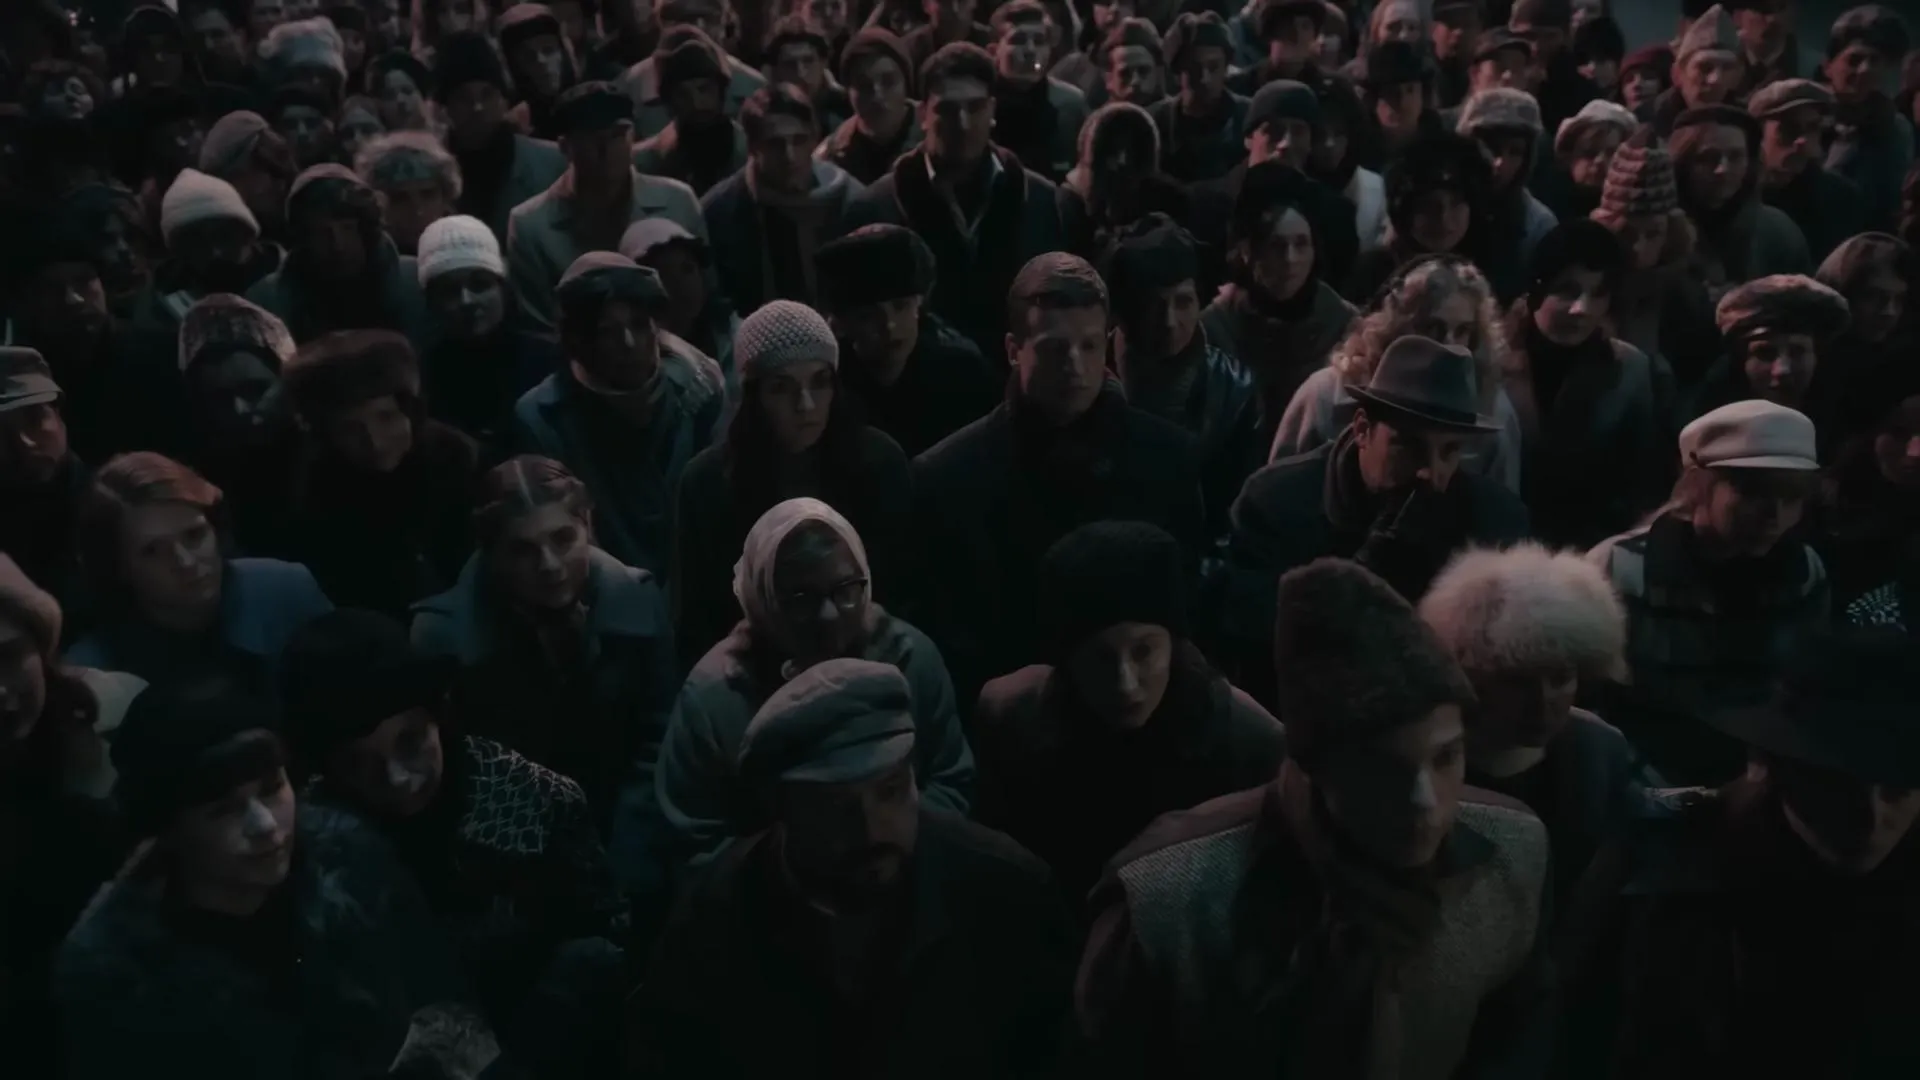
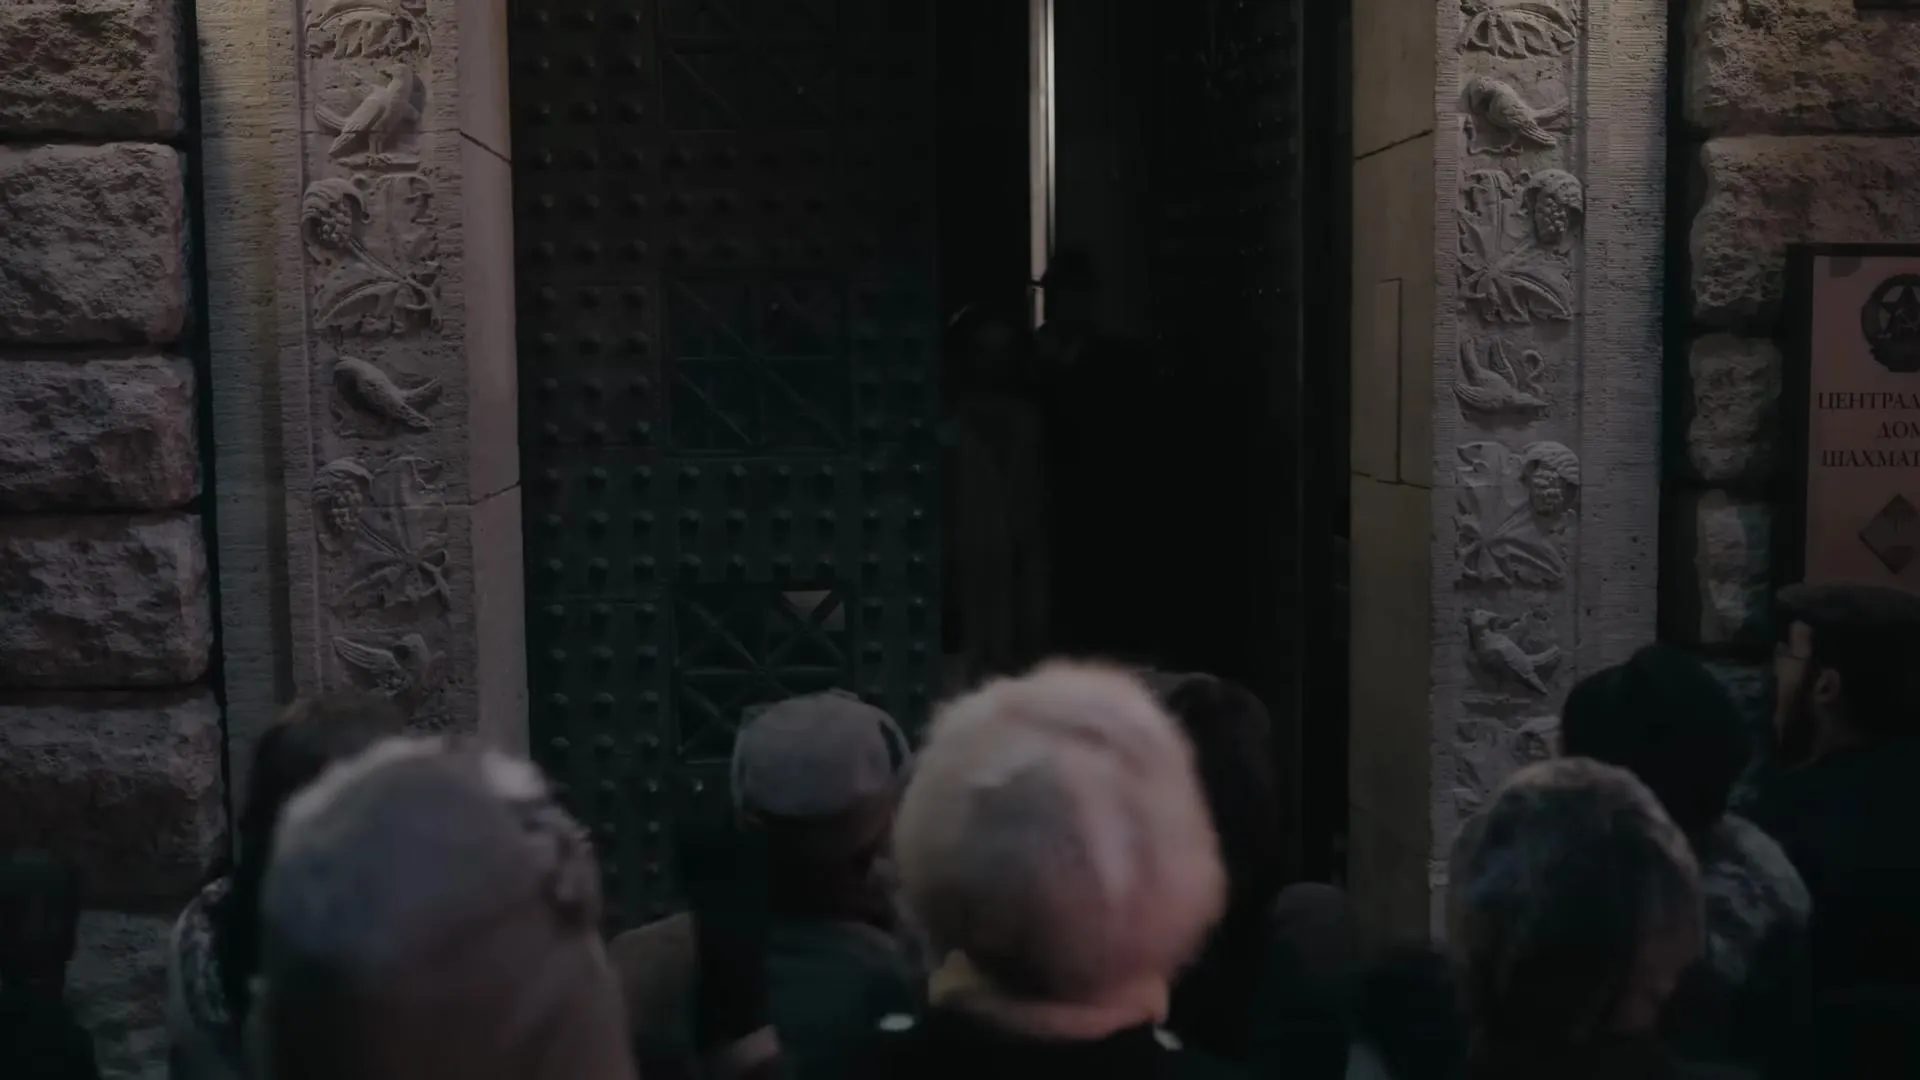
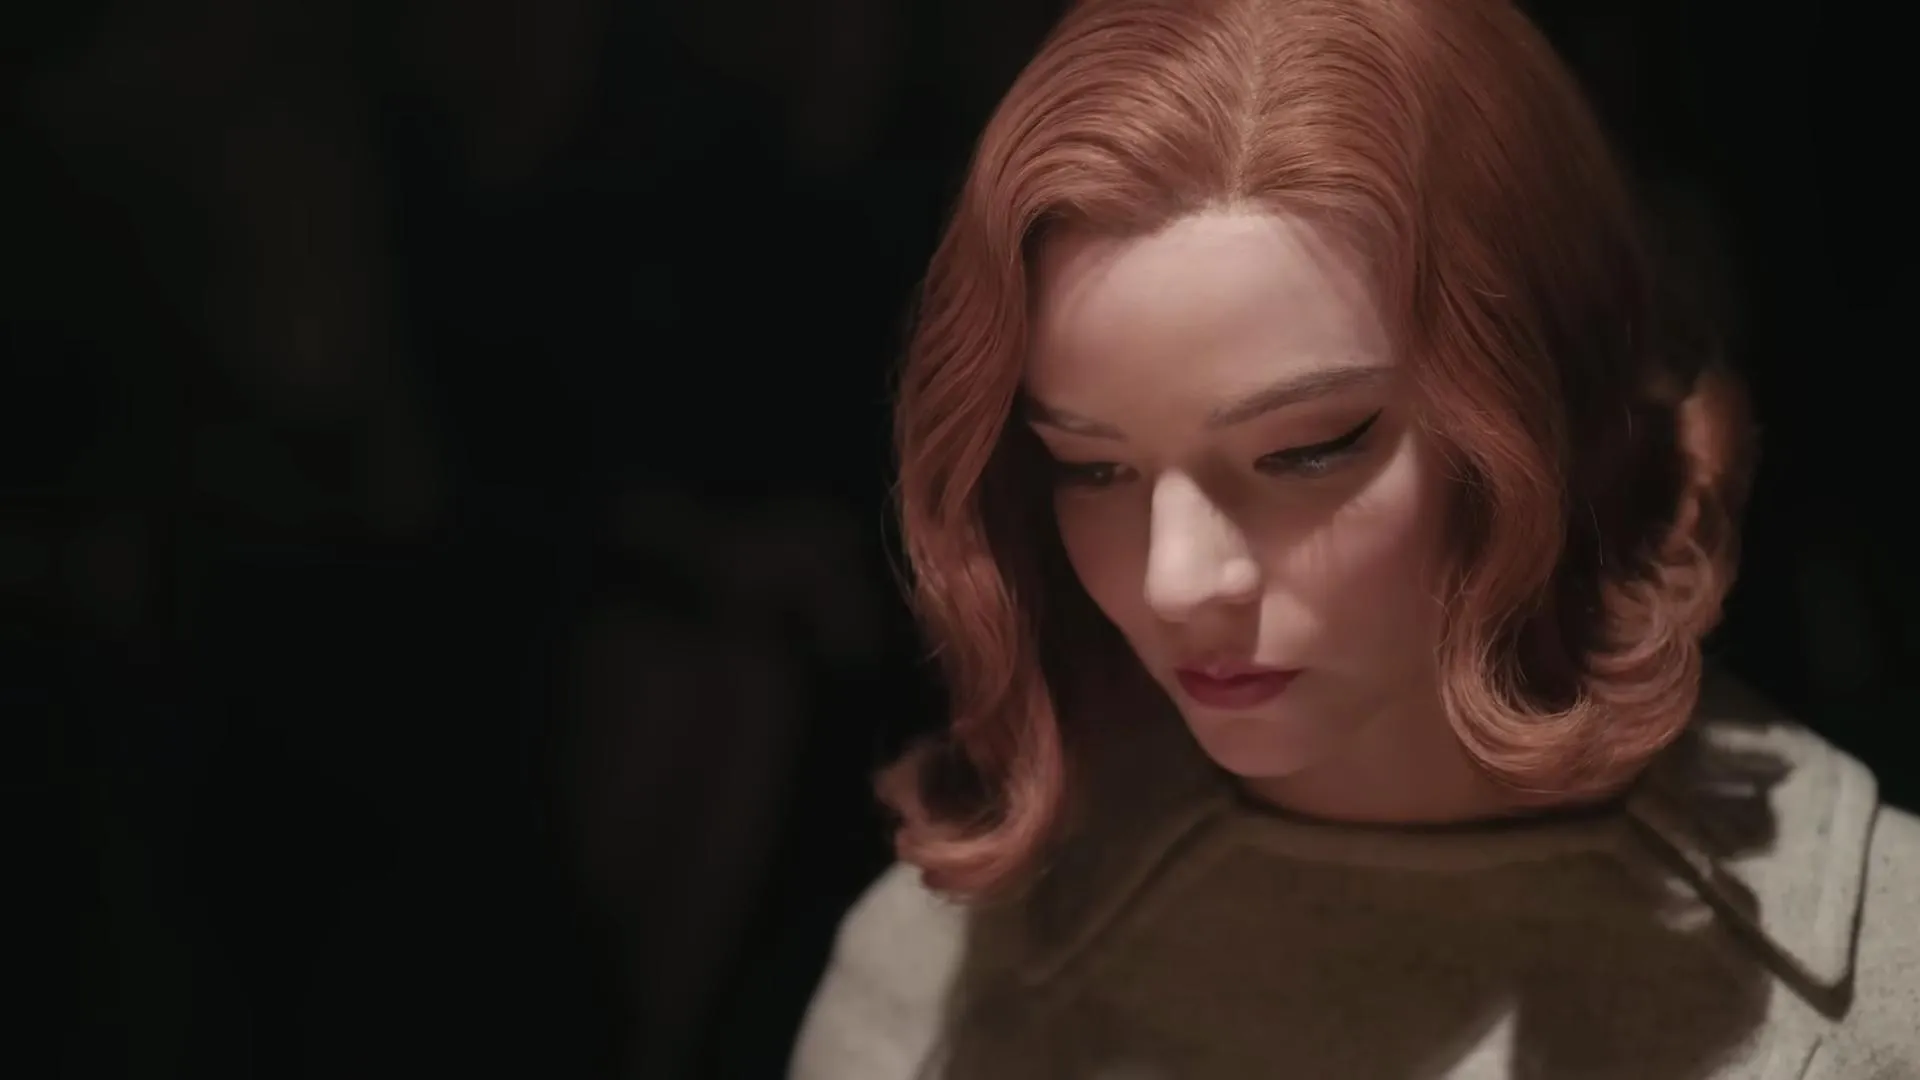

In [14]:
scene_view.select(scene_view.beginning_frame, scene_view.trailer_prompt).limit(3).collect()

In [21]:
# View ALL scenes with their AI-generated trailer prompts
scene_view.select(
    scene_view.pos,
    scene_view.trailer_prompt
).collect()

pos,trailer_prompt
1,"Dimly lit crowd of stoic faces, each a portrait of silent anticipation, the atmosphere thick with unspoken tension. A sea of fur hats and somber expressions, a whisper of defiance in the cold winter air."
4,"A grand, shadowed doorway, intricately carved, stands ominous against a crowd of blurred faces. A single shaft of light cuts through the darkness."
2,"Movie: The Queen's Gambit. Description: In a Kentucky orphanage in the 1950s, a young girl discovers she has an astonishing gift for chess while struggling with addiction. Transcript_text: [Silence]. Close up on a focused young woman with red hair, gazing down with furrowed brows, a single light highlighting her face against a dark background. Deep shadows embrace her face as she contemplates her next move."
0,"Movie: ""The Accountant"". Description: A forensic accountant uncooks the books for dangerous clients. This frame is from one scene. What is said: (Sighs) ""Who said that?"". A grim man in a dark suit stares downwards under stark, dramatic lighting. The shadows coalesce around his face, revealing a furrowed brow and intense gaze."
7,"Movie: ""The Queen's Gambit"". Description: An orphaned girl turns out to be a chess prodigy and fights her demons on her way to becoming the world's best chess player. This frame is from one scene. What is said: Yes. A young woman in a pristine white coat and matching hat walks among crowds of men playing chess in a grey park in Russia. A close up, low angle."
3,"A silhouette of a woman in a dimly lit room, her hand near her face in contemplation. An ambiguous painting hangs on the wall, shrouded in shadows."
9,"Movie: The Queen's Gambit. Description: A young orphaned girl is discovered to possess an astonishing gift for chess while on a trajectory to self-destruction. What is said: [SCATTTERED NOISES] Close-up portrait of a woman with red hair, wearing a white beret, eyes filled with sharp calculation against a backdrop of blurry faces. Soft focus, cold colors, heavy atmosphere."
5,"A young woman in a patterned coat stands beside a black car, Moscow's skyline glowing distantly at dusk. Gloved hand reaches for the car door."
6,"East Berlin street in winter: A woman in white emerges from a sleek black limousine. A pallid tenement building towers in the background, its many windows like vacant eyes."
8,"A woman in a white coat and pompom hat is greeted by a beaming elderly man in a wool cap on a snowy day. Soft, diffused light highlights the joy on their faces as they meet in a bustling town square."


## 03 - Create New Content

Now you can generate visual content from your trailer prompts. You have three options:

- **Option A: Generate Images** (faster, cheaper - good for testing) with Gemini's `imagen-4.0-generate-001` model
- **Option B: Generate Videos from Prompt + Image** (slower, more expensive - production quality) with Gemini's `veo-3.1-generate-preview` model
- **Option C: Generate Videos from Image Only** (slower, more expensive - simpler approach) with Gemini's `veo-3.1-generate-preview` model

We'll demonstrate all three approaches.

In [15]:
# OPTION A: Generate an image for one scene (faster, cheaper)
scene_image = scene_view.where(scene_view.pos == 2).select(
    scene_view.pos,
    scene_view.trailer_prompt,
    trailer_image=pxtf.gemini.generate_images(
        prompt=scene_view.trailer_prompt,
        model='imagen-4.0-generate-001'
    )
).collect()

pos,trailer_prompt,trailer_image
2,"Movie: The Queen's Gambit. Description: In a Kentucky orphanage in the 1950s, a young girl discovers she has an astonishing gift for chess while struggling with addiction. Transcript_text: [Silence]. Close up on a focused young woman with red hair, gazing down with furrowed brows, a single light highlighting her face against a dark background. Deep shadows embrace her face as she contemplates her next move.",

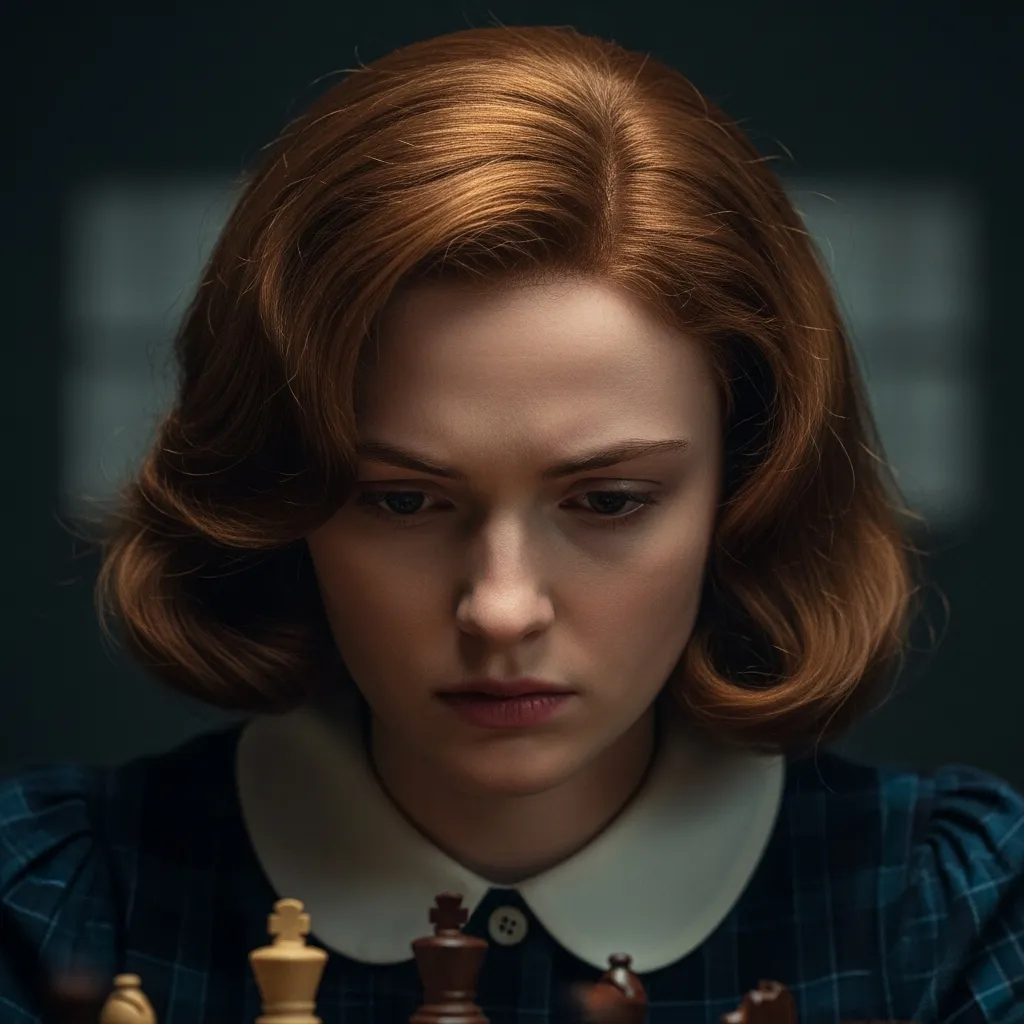

In [16]:
# View the AI-generated image for the scene
scene_image

In [23]:
# OPTION B: Generate a video for one scene (slower, more expensive)
# NOTE: Video generation is experimental and may fail due to API limitations

# Image-to-video with prompt (animates a resized frame based on the trailer prompt)
scene_trailer = scene_view.where(scene_view.pos == 2).select(
    scene_view.pos,
    scene_view.trailer_prompt,
    trailer_video=pxtf.gemini.generate_videos(
        prompt=scene_view.trailer_prompt,
        image=scene_view.beginning_frame.resize((640, 360)),
        model='veo-3.1-generate-preview',
        config={'duration_seconds': 4}
    )
).collect()

: 

In [ ]:
# View the AI-generated trailer for the scene
scene_trailer 

In [31]:
# OPTION C: Animate an image without prompt (simpler approach)
# NOTE: Video generation is experimental and may fail due to API limitations

# Image-to-video: animates a resized frame (smaller size for compatibility)
scene_animation = scene_view.where(scene_view.pos == 2).select(
    scene_view.pos,
    animated_video=pxtf.gemini.generate_videos(
        image=scene_view.beginning_frame.resize((640, 360)),
        model='veo-3.1-generate-preview',
        config={'duration_seconds': 4}
    )
).collect()

pos,animated_video
2,

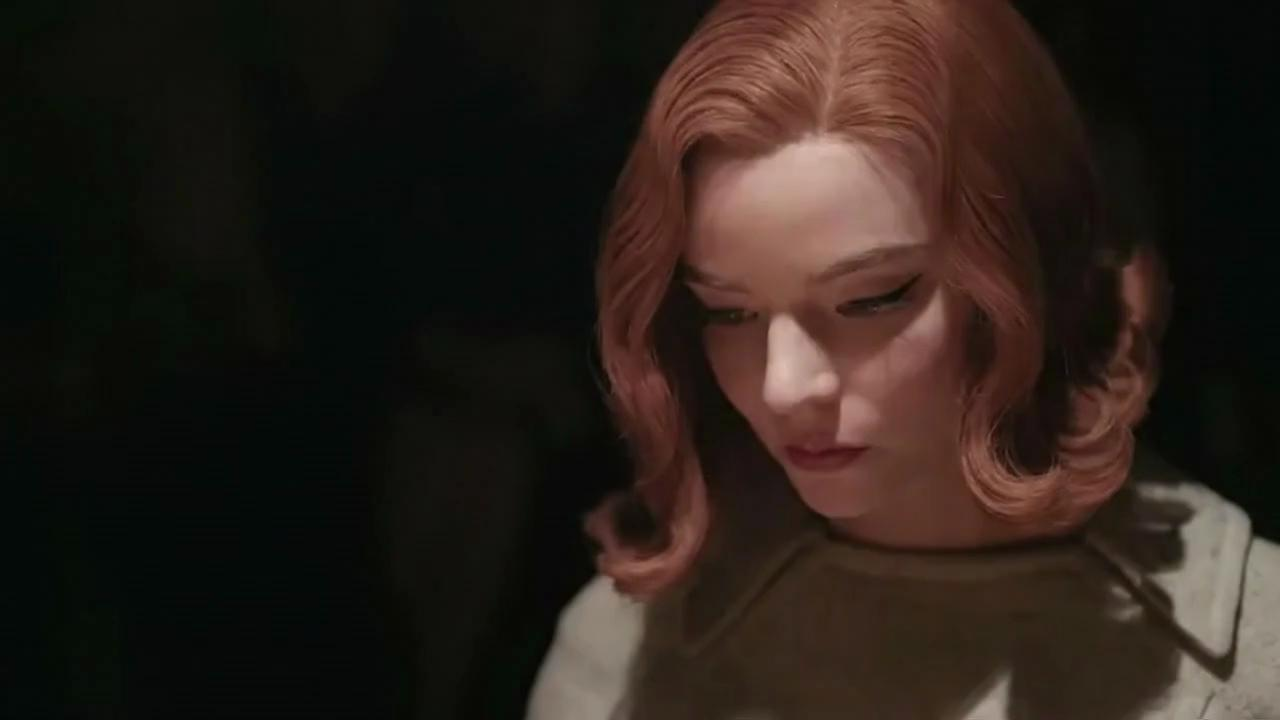

In [32]:
# View the animated video
scene_animation

You've tested image and video generation on individual scenes using `.select().where()`. 

But what if you want to generate images for **all** scenes automatically?

## 04 - Generate Across All Scenes

Now let's add image generation as a computed column to process all scenes automatically.

In [24]:
# Add trailer image generation as a computed column
scene_view.add_computed_column(
    trailer_image=pxtf.gemini.generate_images(
        prompt=scene_view.trailer_prompt,
        model='imagen-4.0-generate-001'
    ),
    if_exists='replace'
)

Added 10 column values with 0 errors in 13.54 s (0.74 rows/s)


10 rows updated.

This computed column will automatically generate trailer images for all 10 scenes.

**What you built:**
- Frame extraction pipeline (`beginning_frame`)
- AI prompt generation pipeline (`trailer_prompt`)
- Image generation pipeline (`trailer_image`)
- All applied automatically to every scene

**What happens next:**

If you add more video scenes to your base table (in Act 2), those new scenes automatically flow through to `scene_view`, and the computed columns process them without any additional code:

- New scene added → `beginning_frame` extracted → `trailer_prompt` generated → `trailer_image` created

The workflow is defined once and applies to all data—past, present, and future.

pos,trailer_prompt,trailer_image
1,"Dimly lit crowd of stoic faces, each a portrait of silent anticipation, the atmosphere thick with unspoken tension. A sea of fur hats and somber expressions, a whisper of defiance in the cold winter air.",
2,"Movie: The Queen's Gambit. Description: In a Kentucky orphanage in the 1950s, a young girl discovers she has an astonishing gift for chess while struggling with addiction. Transcript_text: [Silence]. Close up on a focused young woman with red hair, gazing down with furrowed brows, a single light highlighting her face against a dark background. Deep shadows embrace her face as she contemplates her next move.",
4,"A grand, shadowed doorway, intricately carved, stands ominous against a crowd of blurred faces. A single shaft of light cuts through the darkness.",
7,"Movie: ""The Queen's Gambit"". Description: An orphaned girl turns out to be a chess prodigy and fights her demons on her way to becoming the world's best chess player. This frame is from one scene. What is said: Yes. A young woman in a pristine white coat and matching hat walks among crowds of men playing chess in a grey park in Russia. A close up, low angle.",
0,"Movie: ""The Accountant"". Description: A forensic accountant uncooks the books for dangerous clients. This frame is from one scene. What is said: (Sighs) ""Who said that?"". A grim man in a dark suit stares downwards under stark, dramatic lighting. The shadows coalesce around his face, revealing a furrowed brow and intense gaze.",
9,"Movie: The Queen's Gambit. Description: A young orphaned girl is discovered to possess an astonishing gift for chess while on a trajectory to self-destruction. What is said: [SCATTTERED NOISES] Close-up portrait of a woman with red hair, wearing a white beret, eyes filled with sharp calculation against a backdrop of blurry faces. Soft focus, cold colors, heavy atmosphere.",
3,"A silhouette of a woman in a dimly lit room, her hand near her face in contemplation. An ambiguous painting hangs on the wall, shrouded in shadows.",
6,"East Berlin street in winter: A woman in white emerges from a sleek black limousine. A pallid tenement building towers in the background, its many windows like vacant eyes.",
5,"A young woman in a patterned coat stands beside a black car, Moscow's skyline glowing distantly at dusk. Gloved hand reaches for the car door.",
8,"A woman in a white coat and pompom hat is greeted by a beaming elderly man in a wool cap on a snowy day. Soft, diffused light highlights the joy on their faces as they meet in a bustling town square.",

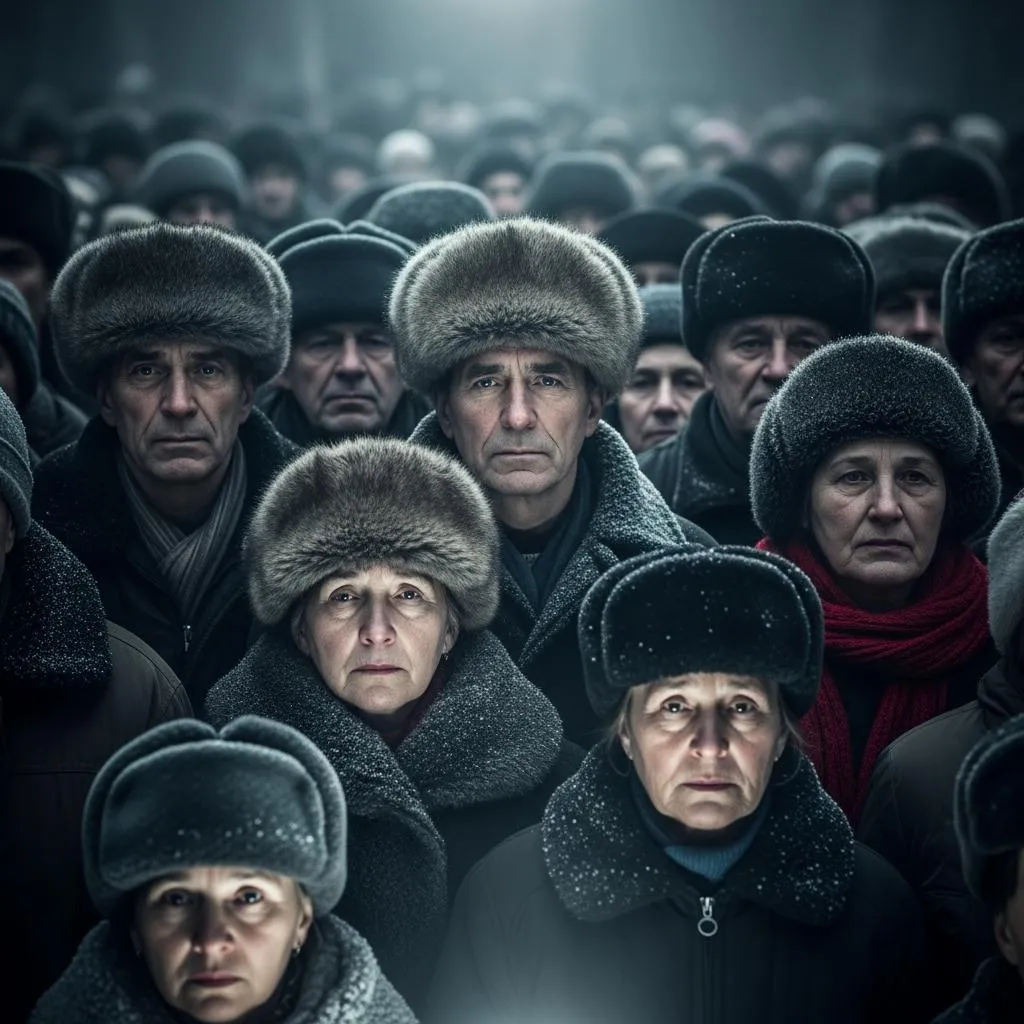
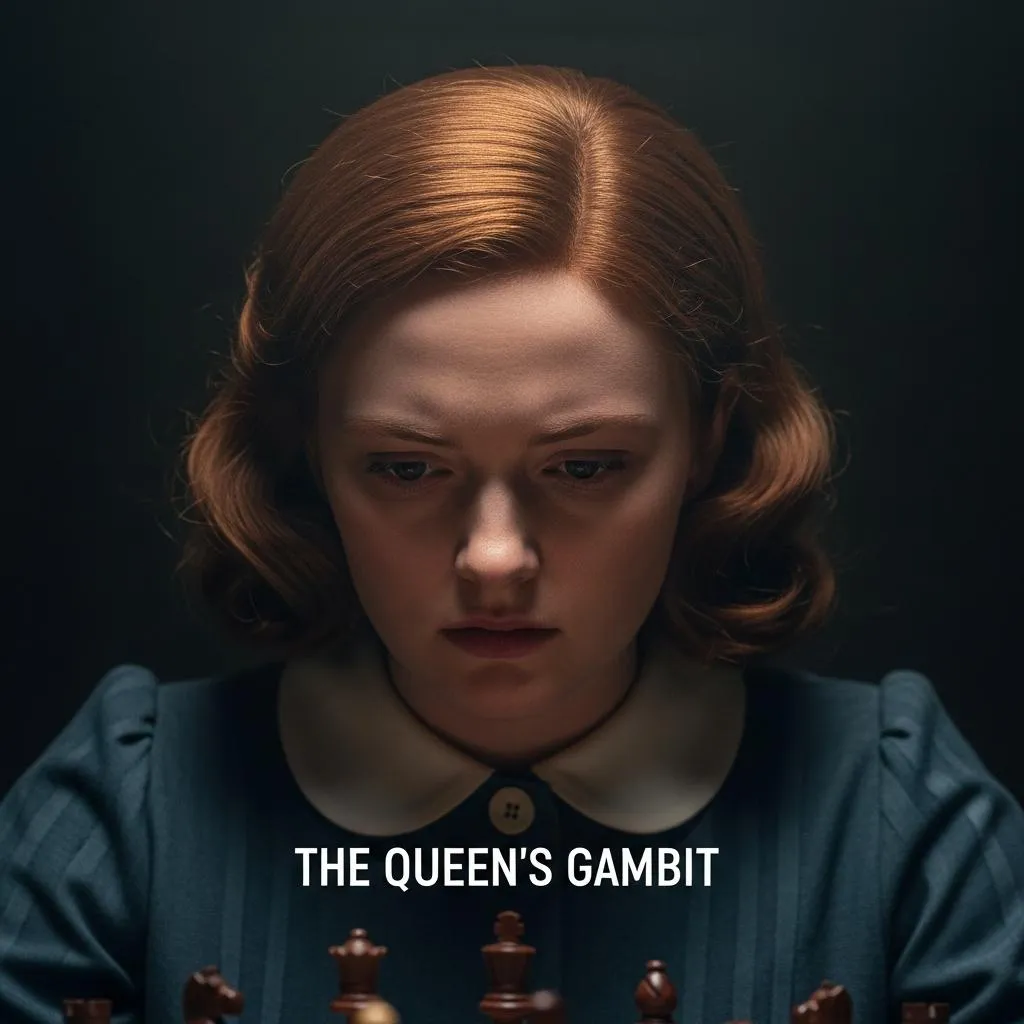
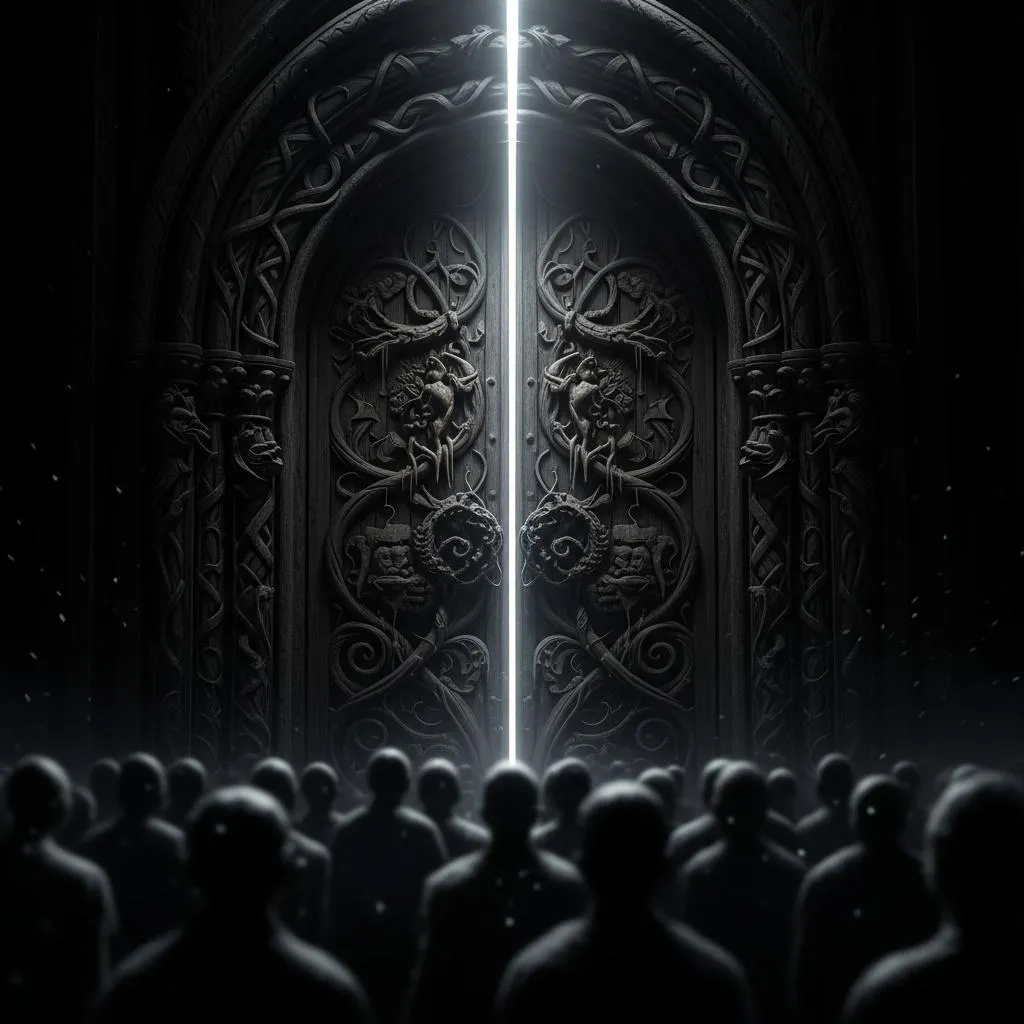
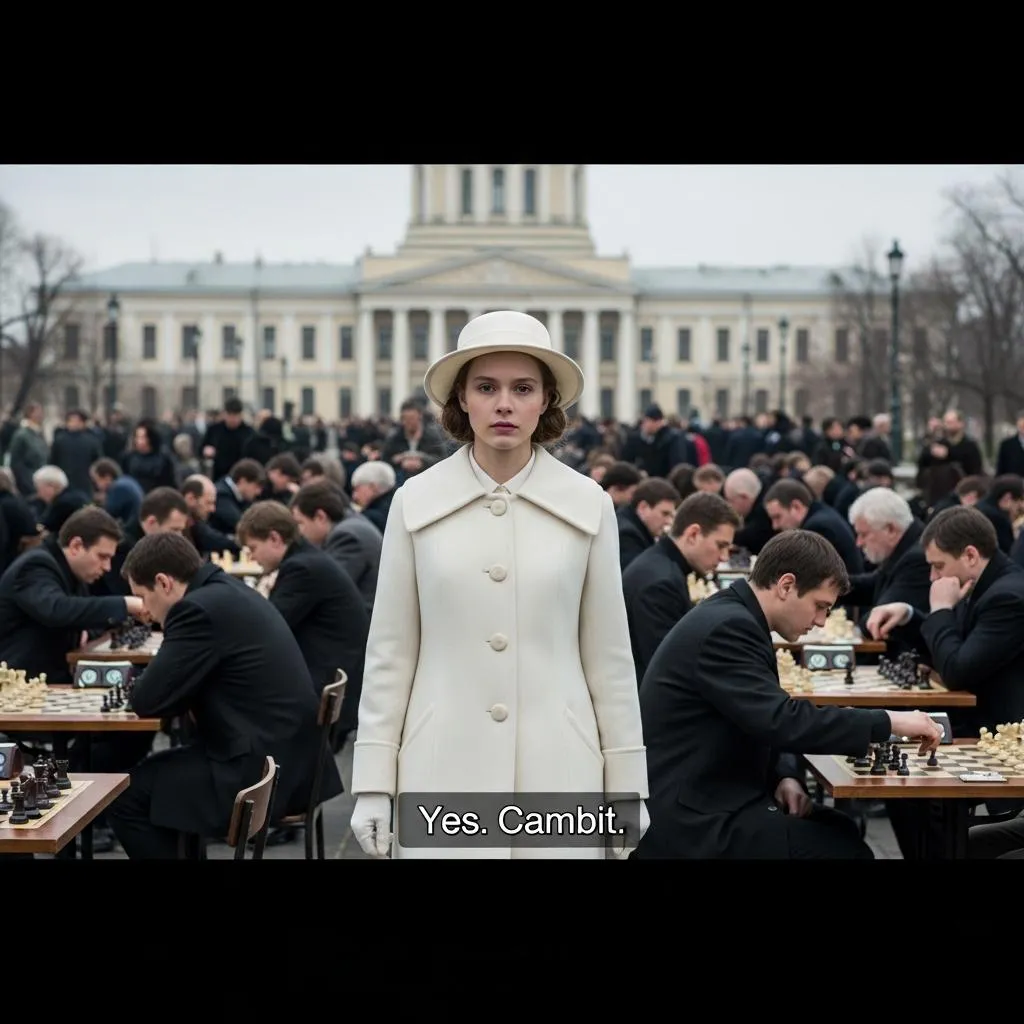
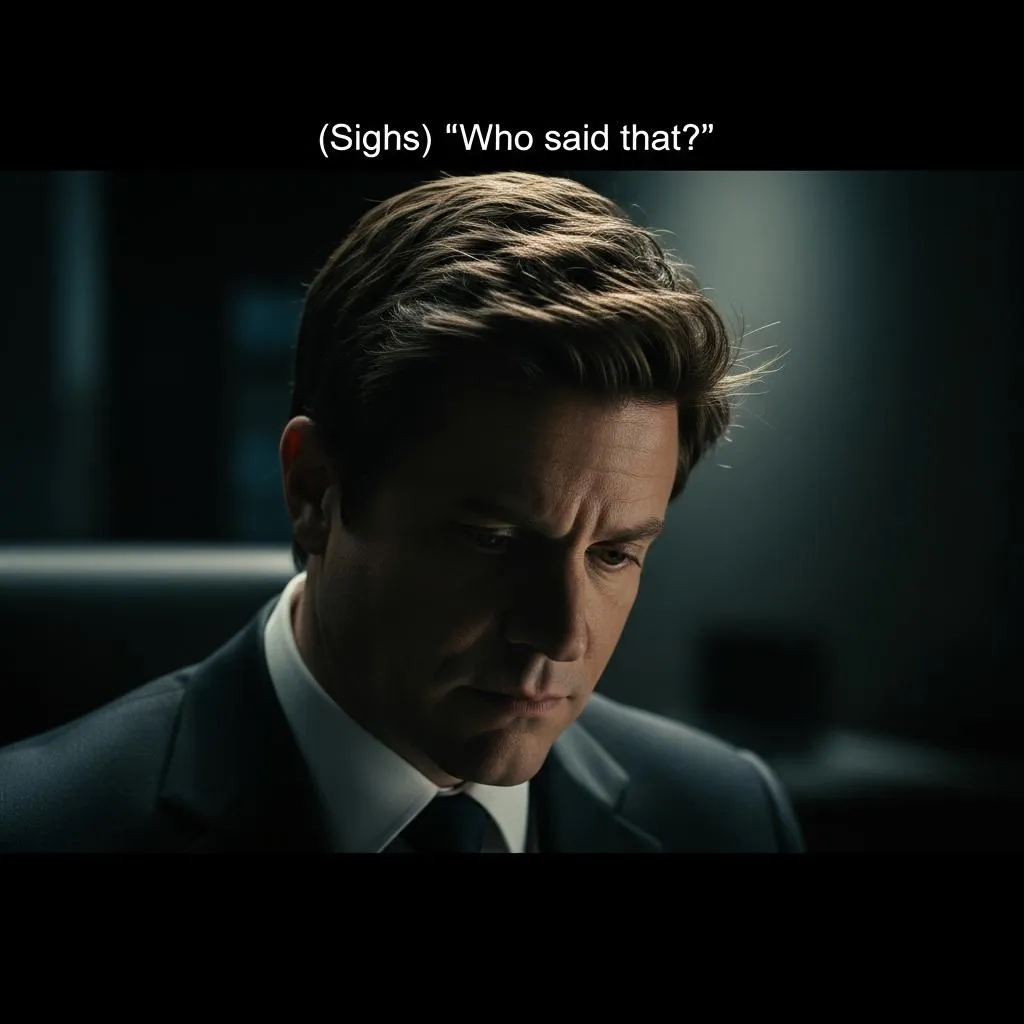
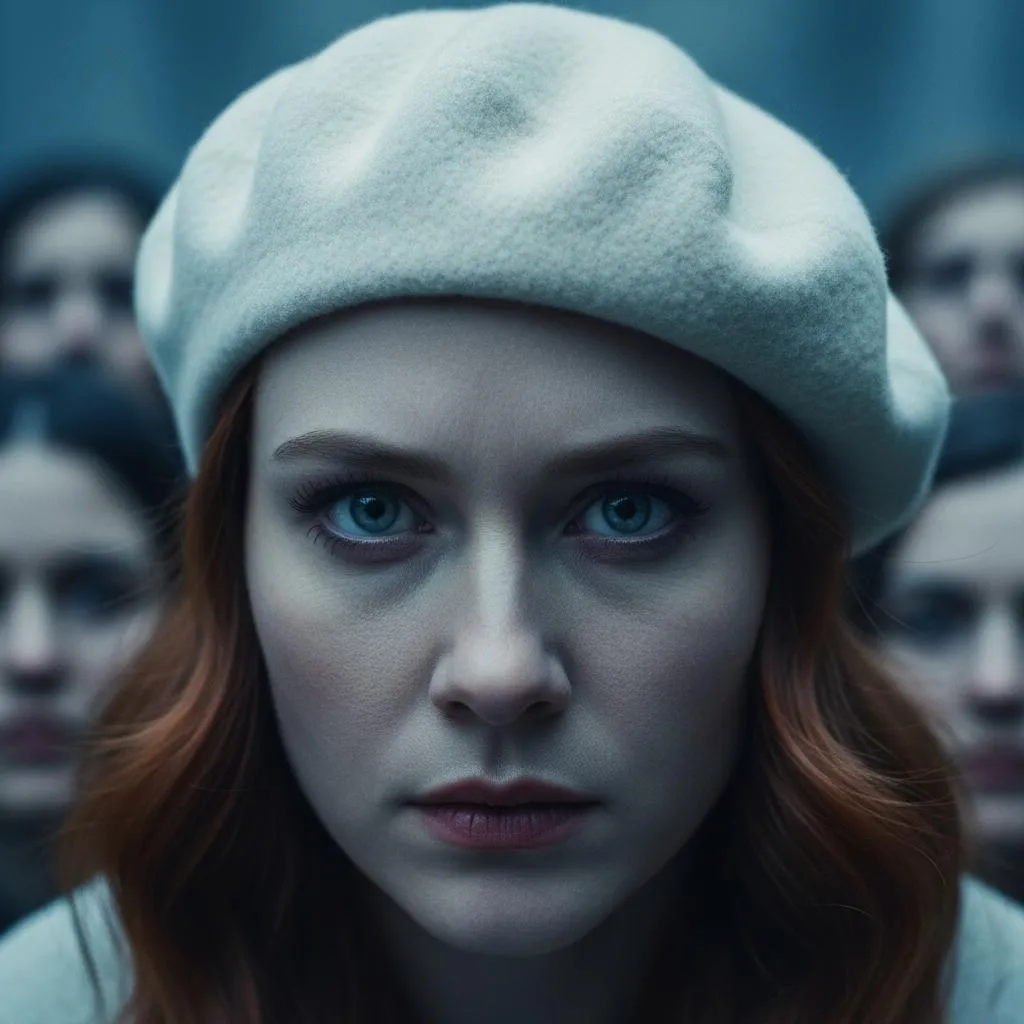
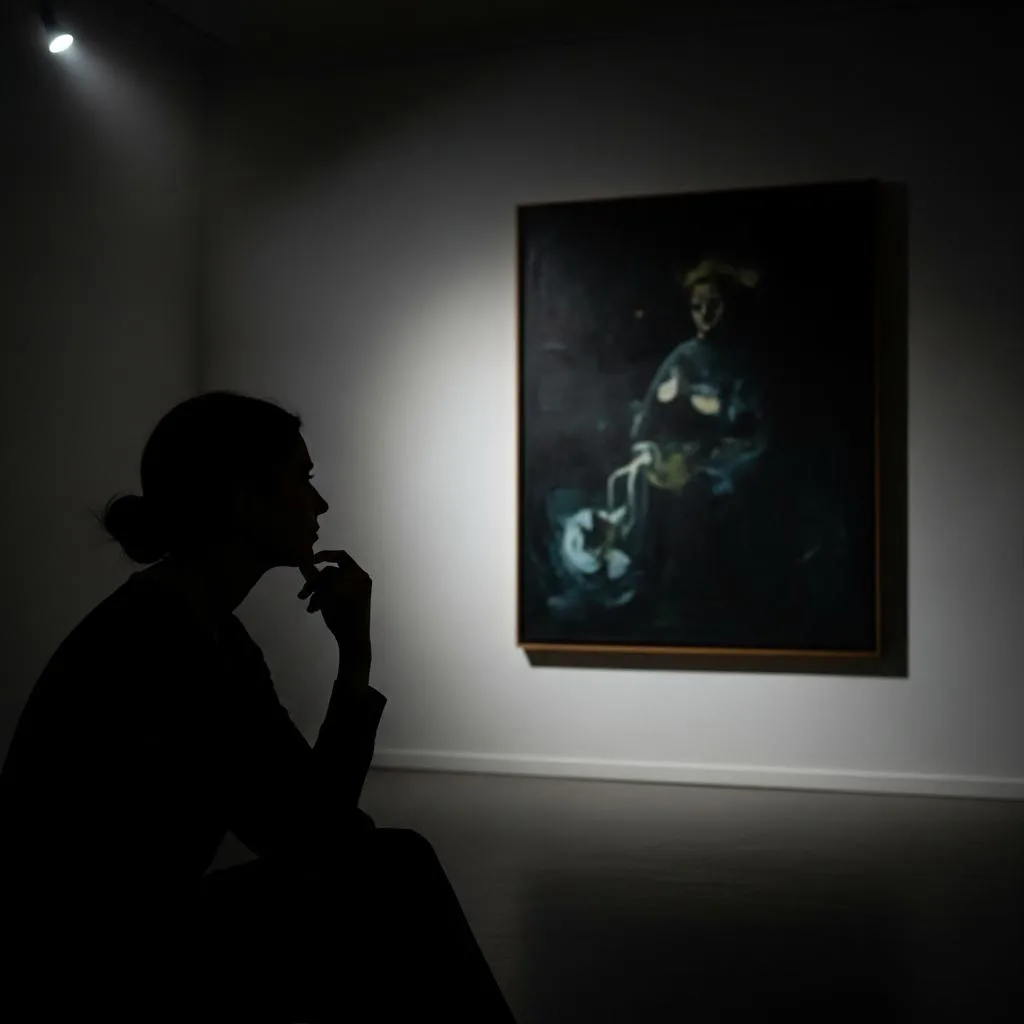
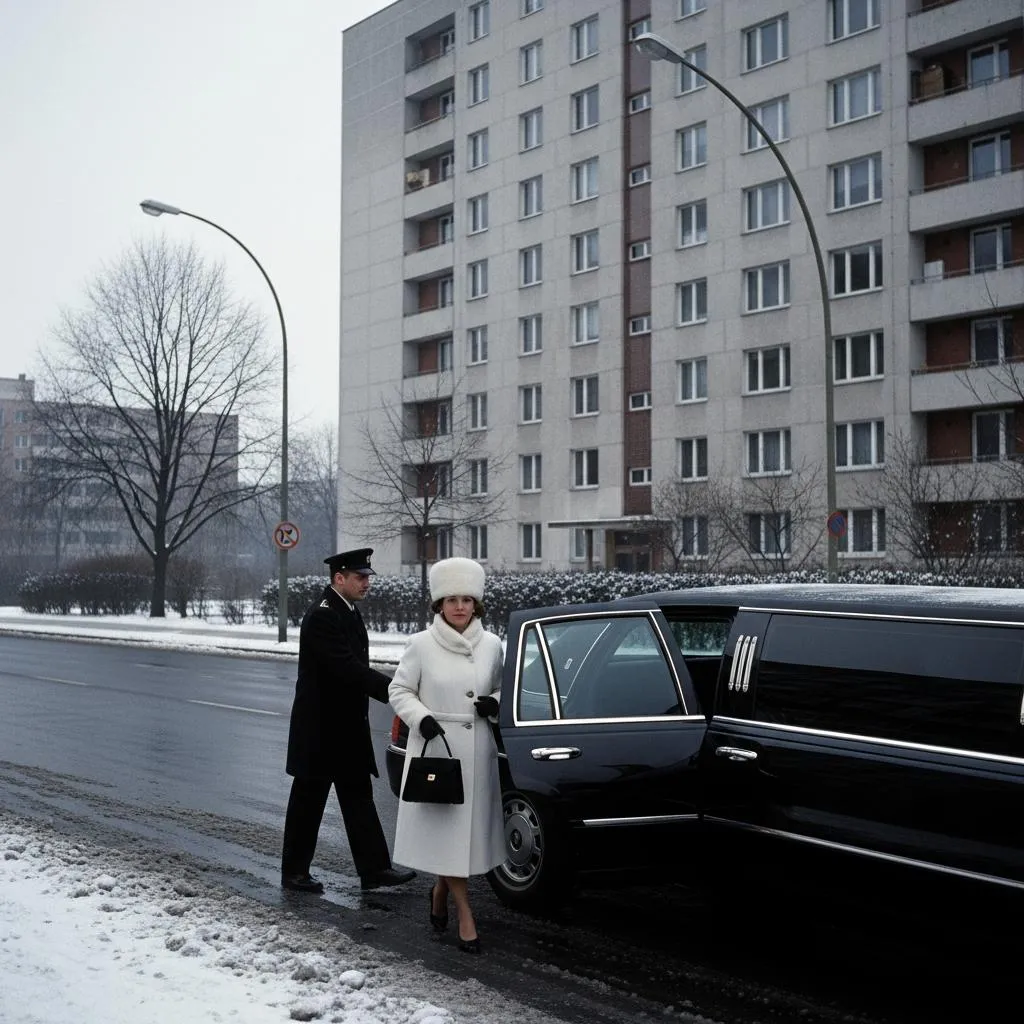
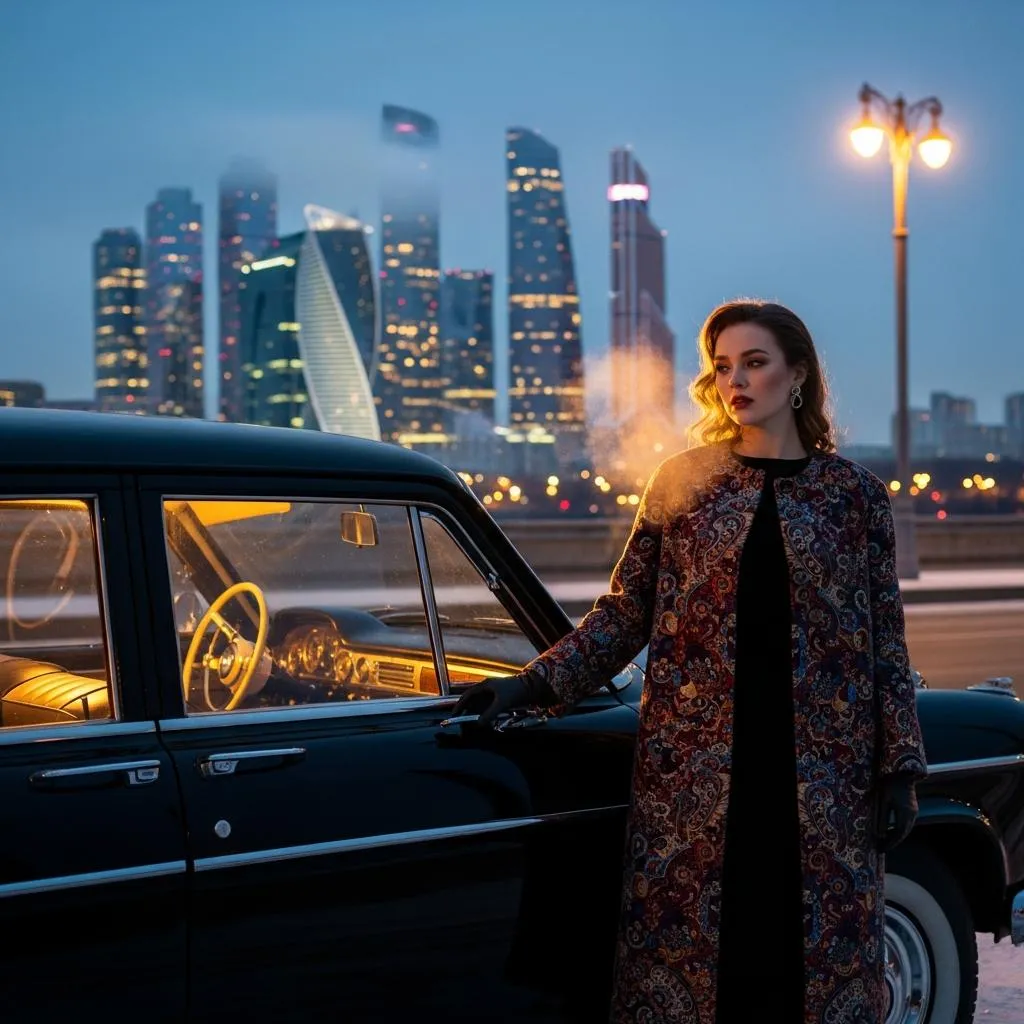
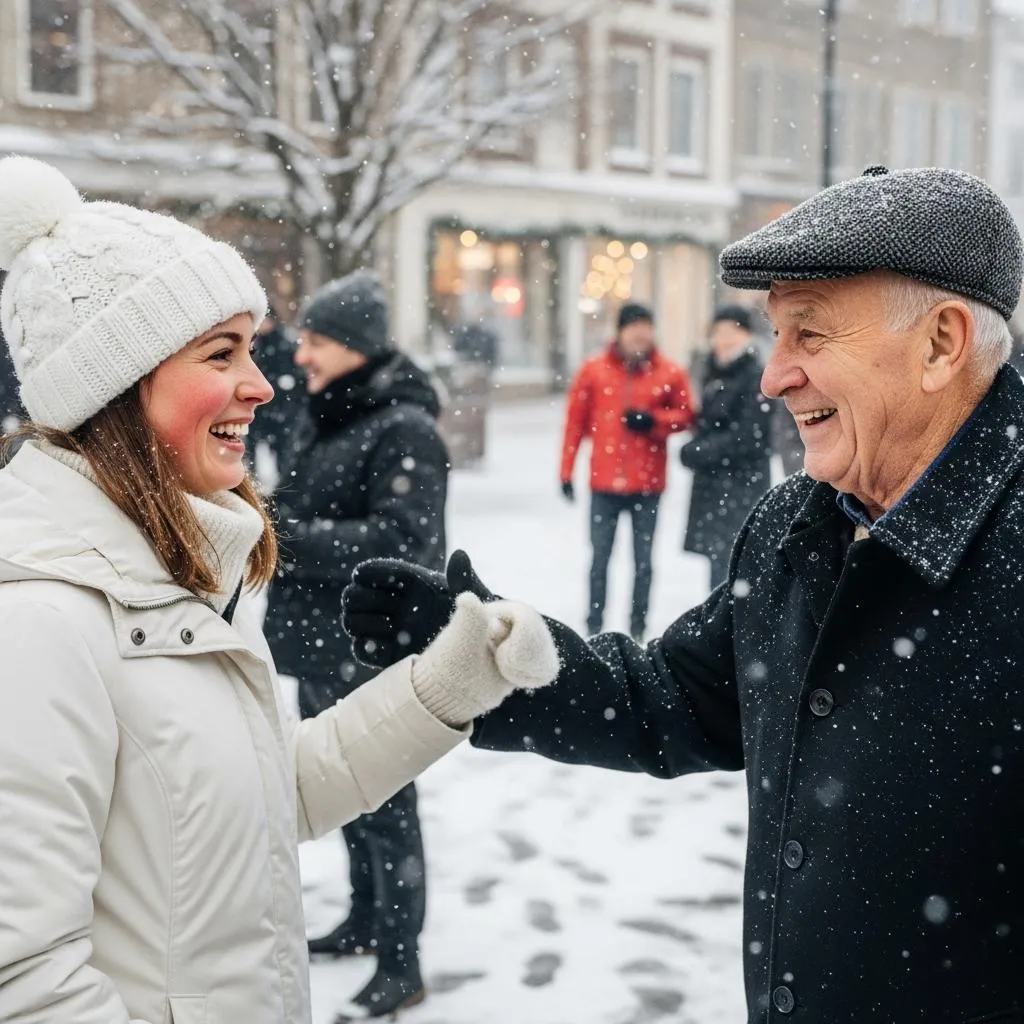

In [25]:
# View all scenes with their generated images
scene_view.select(
    scene_view.pos,
    scene_view.trailer_prompt,
    scene_view.trailer_image
).show()

## 05 - Experiment with Different Styles

The same multimodal pattern works for any creative style - you just change the prompt.

Let's explore how different prompt styles create dramatically different outputs, all using the same underlying workflow.

### Era-Specific Movie Poster Styles

Here are three alternative prompt expressions that reimagine scenes as vintage movie posters from different decades. Each uses the same multimodal inputs (frame image, transcript, movie context) but with era-specific aesthetic instructions.

In [26]:
# 1950s Movie Poster Style
# Bold hand-painted typography, dramatic poses, vibrant primary colors, classic Hollywood glamour

poster_1950s_prompt_expr = pxtf.gemini.generate_content(
    contents=[
        f'Create a 1950s movie poster prompt for "{scene_view.title}". Based on this frame and dialogue: {scene_view.transcript_text}. Write ONLY a 1-2 sentence prompt describing a vintage 1950s poster with bold hand-painted typography, dramatic poses, vibrant primary colors, and classic Hollywood glamour aesthetic. No preamble.',
        scene_view.beginning_frame
    ],
    model='gemini-2.0-flash-exp'
)['candidates'][0]['content']['parts'][0]['text']

In [ ]:
# 1970s Movie Poster Style
# Earthy tones, gritty realism, bold geometric typography, counterculture design

poster_1970s_prompt_expr = pxtf.gemini.generate_content(
    contents=[
        f'Create a 1970s movie poster prompt for "{scene_view.title}". Frame content: {scene_view.transcript_text}. Write ONLY a 1-2 sentence prompt with 1970s aesthetic - earthy tones, gritty realism, bold geometric typography, and counterculture design elements. No preamble.',
        scene_view.beginning_frame
    ],
    model='gemini-2.0-flash-exp'
)['candidates'][0]['content']['parts'][0]['text']

In [ ]:
# 1980s Movie Poster Style
# Neon colors, chrome effects, airbrushed style, dramatic backlighting

poster_1980s_prompt_expr = pxtf.gemini.generate_content(
    contents=[
        f'Create a 1980s movie poster prompt for "{scene_view.title}". Context: {scene_view.transcript_text}. Write ONLY a 1-2 sentence prompt with 1980s aesthetic - neon colors, chrome effects, airbrushed style, dramatic backlighting, and bold outlined typography. No preamble.',
        scene_view.beginning_frame
    ],
    model='gemini-2.0-flash-exp'
)['candidates'][0]['content']['parts'][0]['text']

### Test a Style on One Scene

You can test any of these expressions on a single scene before adding them as computed columns.

In [29]:
# Test the 1950s style on scene 2 - generate both prompt and image
scene_view.where(scene_view.pos == 2).select(
    scene_view.pos,
    poster_1950s_prompt=poster_1950s_prompt_expr,
    poster_1950s_image=pxtf.gemini.generate_images(
        prompt=poster_1950s_prompt_expr,
        model='imagen-4.0-generate-001'
    )
).collect()

: 

### Add as Computed Columns (Optional)

To generate these styles across all scenes, add them as computed columns:

```python
# Add any or all of these to your scene_view
scene_view.add_computed_column(poster_1950s_prompt=poster_1950s_prompt_expr)
scene_view.add_computed_column(poster_1970s_prompt=poster_1970s_prompt_expr)
scene_view.add_computed_column(poster_1980s_prompt=poster_1980s_prompt_expr)
```

Once added, these columns will automatically process all existing scenes and any new scenes added in the future.

You can then use these prompts with `pxtf.gemini.generate_images()` to create actual poster images in each style.